In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(231)
print(tf.__version__)

import time
import math
from matplotlib import pyplot as plt

/Documents/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.11.0


In [578]:
hparams = tf.contrib.training.HParams(
    batch_size=100,
    in_seq_len=61,
    input_dim=5,
    out_seq_len=61,
    output_dim=1,
    num_layers=2,
    neurons_unit=32,
    learning_rate = 0.001,
    lr_decay = 1,
    lambd = 1e-6,
    datagen = 'prodn',
    logs_path = '/tmp/tensorflow_logs')

### Define Data Generator

In [651]:
# Load production dataset
if hparams.datagen == 'prodn':
    prodn = pd.read_pickle('../full_6d.pkl').values
    #dataset = np.nan_to_num(prodn)[2:1002]
    #mask = np.isfinite(prodn)[2:1002]
    dataset = np.vstack((np.nan_to_num(prodn)[2:102,i:i+500] for i in range(hparams.in_seq_len)))
    mask = np.vstack((np.isfinite(prodn)[2:102,i:i+500] for i in range(hparams.in_seq_len)))

# Create synthetic sine wave data
if hparams.datagen == 'sin':
    dataset = np.zeros((10 * hparams.batch_size, 10 * hparams.in_seq_len))
    dataset[1:,0] = np.random.randn(10 * hparams.batch_size-1)
    for i in range(dataset.shape[1] - 1):
        dataset[:,i+1] = dataset[:,i] + 2 * np.pi / hparams.in_seq_len
    dataset = np.sin(dataset) + 1
    mask = np.ones_like(dataset)

# Reshape data
in_len, out_len = hparams.in_seq_len, hparams.out_seq_len
end_pos = in_len * (hparams.input_dim - 1) + 1

# x.shape = (n_obs, in_seq_len, input_dim)
x = np.array([dataset[:,pos:pos+in_len] for pos in range(0,end_pos,hparams.in_seq_len)])
x = np.rollaxis(x, 0, 3) / np.max(dataset, axis=1)
x = x[:,:,:,np.newaxis]

y =   dataset[:,end_pos+in_len:end_pos+in_len+out_len, np.newaxis] / np.max(dataset)
y_mask = mask[:,end_pos+in_len:end_pos+in_len+out_len, np.newaxis]

del(dataset, mask)
print(x.shape, y.shape, y_mask.shape)

ValueError: operands could not be broadcast together with shapes (6100,61,5) (6100,1) 

In [626]:
dataset = tf.data.Dataset.from_tensor_slices((x.astype(np.float32), y.astype(np.float32), y_mask.astype(np.float32)))
dataset = dataset.batch(hparams.batch_size, drop_remainder=True)

### Define Model

In [198]:
class Attention(tf.keras.Model):
    def __init__(self, hidden_size, d_model, dropout=0.1):
        super(Attention, self).__init__()
        self.d_k = d_model

        self.q_dense_layer = tf.keras.layers.Dense(hidden_size, use_bias=False, name="q")
        self.k_dense_layer = tf.keras.layers.Dense(hidden_size, use_bias=False, name="k")
        self.v_dense_layer = tf.keras.layers.Dense(hidden_size, use_bias=False, name="v")
        
        self.out_dense_layer = tf.keras.layers.Dense(hidden_size, use_bias=False,
                                              name="output_transform")
        self.dropout = dropout
    
    def attention(self, query, key, value, mask=None, dropout=None):
        "Compute 'Scaled Dot Product Attention'"
        # Function accepts tensor of shape (m * d_p * d_k)
        assert len(query.shape) == 3
        m, d_p, d_k = query.shape
        
        scores = tf.matmul(query, key, transpose_b=True) / d_k.value ** 0.5
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = tf.keras.layers.Softmax(axis = -1)(scores)
        if dropout is not None:
            p_attn = tf.keras.layers.Dropout(dropout)(p_attn)
        return tf.matmul(p_attn, value), p_attn
        
    def call(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
            # Note: Adjusted from mask = mask.unsqueeze(2)
        nbatches = query.shape[0]
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query = self.q_dense_layer(tf.squeeze(query))
        key   = self.k_dense_layer(tf.squeeze(key))
        value = self.v_dense_layer(tf.squeeze(value))

        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = self.attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        x = self.out_dense_layer(x)
        x = tf.keras.backend.expand_dims(x, axis=-1)
        return x

Simple attention only model with affine classifier

In [485]:
class AttentionModel(tf.keras.Model):
    def __init__(self, input_dim, period, output_dim, neurons_unit):
        super(AttentionModel, self).__init__()
        # store hparams
        self.input_dim    = input_dim
        self.output_dim   = output_dim
        self.period       = period
        self.neurons_unit = neurons_unit

        # define model
        self.attn_1  = Attention(self.neurons_unit, self.input_dim, dropout=None)
        self.flatten = tf.keras.layers.Flatten()
        #self.fc_1    = tf.keras.layers.Dense(period, activation='relu',
        #                                    bias_initializer=tf.keras.initializers.Constant(value=0.5))

        self.fc_1    = tf.keras.layers.Dense(period, use_bias=False)
        self.leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.01)

    def call(self, x, mask):
        x_a1 = self.attn_1(x, x, x)

        
        x_a2 = self.flatten(x_a1)
        x_a2 = self.fc_1(x_a2)
        x_a2 = self.leaky_relu(x_a2)
        
        return tf.keras.backend.expand_dims(x_a2, axis=-1) * mask

In [631]:
class AttentionModel(tf.keras.Model):
    """
    attn -> Conv_1x1 -> Conv_3x1
    """
    def __init__(self, input_dim, period, output_dim, neurons_unit):
        super(AttentionModel, self).__init__()
        # store hparams
        self.input_dim    = input_dim
        self.output_dim   = output_dim
        self.period       = period
        self.neurons_unit = neurons_unit

        self.leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.01)

        # define model
        self.attn_1  = Attention(neurons_unit, input_dim, dropout=None)
        
        #self.conv1_1x1 = tf.keras.layers.Conv2D(neurons_unit, (1,neurons_unit), activation='linear')
        #self.conv1_smooth1 = tf.keras.layers.Conv2D(neurons_unit, (1,1), activation='linear')
        #self.conv1_smooth2 = tf.keras.layers.Conv2D(1, (1,1), activation='linear')

        self.flatten = tf.keras.layers.Flatten()
        self.fc_1    = tf.keras.layers.Dense(period, use_bias=False)

    def call(self, x, mask):
        x_a1 = self.attn_1(x, x, x)
        
        #x_c1 = self.conv1_1x1(x_a1)
        #x_c1 = self.leaky_relu(x_c1)
        #x_c1 = self.conv1_smooth1(x_c1)
        #x_c1 = self.leaky_relu(x_c1)
        #x_c1 = self.conv1_smooth2(x_c1)
        #x_c1 = self.leaky_relu(x_c1)
        
        #return x_c1[:,:,:,0] * mask

        x_a2 = self.flatten(x_a1)
        x_a2 = self.fc_1(x_a2)
        x_a2 = self.leaky_relu(x_a2)
        
        return tf.keras.backend.expand_dims(x_a2, axis=-1) * mask

In [275]:
class AttentionModel(tf.keras.Model):
    def __init__(self, input_dim, period, output_dim, neurons_unit):
        super(AttentionModel, self).__init__()
        # store hparams
        self.input_dim    = input_dim
        self.output_dim   = output_dim
        self.period       = period
        self.neurons_unit = neurons_unit

        # define model
        self.attn_1  = Attention(neurons_unit, input_dim, dropout=None)

        self.conv1_1x1 = tf.keras.layers.Conv2D(32, (1,neurons_unit))
        self.conv1_3x1 = tf.keras.layers.Conv2D(32, (3,neurons_unit), padding='valid')
        self.conv1_5x1 = tf.keras.layers.Conv2D(32, (5,neurons_unit), padding='valid')

        self.conv1_cat = tf.keras.layers.Conv2D(32, (1,1), activation='relu')
        
        self.attn_2  = Attention(neurons_unit, neurons_unit, dropout=None)
        self.flatten = tf.keras.layers.Flatten()
        self.fc_1    = tf.keras.layers.Dense(period, activation='relu',
                                            bias_initializer=tf.keras.initializers.Constant(value=0.1))

    def call(self, x, mask):
        x = self.attn_1(x, x, x)
        
        l1_1 = self.conv1_1x1(x)
        l1_3 = tf.concat((x[:,-1:,:,:], x, x[:,:1,:,:]), axis=1)
        l1_3 = self.conv1_3x1(l1_3)
        l1_5 = tf.concat((x[:,-2:,:,:], x, x[:,:2,:,:]), axis=1)
        l1_5 = self.conv1_5x1(l1_5)
        
        l1_c = tf.concat((l1_1, l1_3, l1_5), axis=-1)
        l1_c = self.conv1_cat(l1_c)
        
        x_a2 = self.attn_2(l1_c, l1_c, l1_c)        
        x_a2 = self.flatten(x_a2)
        x_a2 = self.fc_1(x_a2)
        
        return tf.keras.backend.expand_dims(x_a2, axis=-1) * mask

In [ ]:
class Model(tf.keras.Model):
    def __init__(self, input_dim, period, output_dim):
        super(Model, self).__init__()
        # store hparams
        self.input_dim  = input_dim
        self.output_dim = output_dim
        self.period     = period

        """self.pad_3x1 = tf.keras.layers.ZeroPadding2D(((1,1),(0,0)))
        self.pad_5x1 = tf.keras.layers.ZeroPadding2D(((2,2),(0,0)))"""
        
        # define model
        self.conv1_1x1 = tf.keras.layers.Conv2D(32, (1,input_dim))
        self.conv1_3x1 = tf.keras.layers.Conv2D(32, (3,input_dim), padding='valid')
        self.conv1_5x1 = tf.keras.layers.Conv2D(32, (5,input_dim), padding='valid')

        self.conv1_cat = tf.keras.layers.Conv2D(32, (1,1), activation='relu')
        self.conv1_smooth1 = tf.keras.layers.Conv2D(32, (3,1), activation='relu')
        self.conv1_smooth2 = tf.keras.layers.Conv2D(16, (3,1), activation='relu')
        
        #self.fc_out = tf.keras.layers.Dense(period, activation='relu', bias_initializer='ones')
        self.fc_out = tf.keras.layers.Dense(period, activation='relu',
                                            bias_initializer=tf.keras.initializers.Constant(value=0.1))


    def call(self, x, mask):
        """l1_1 = self.conv1_1x1(x)
        l1_3 = self.pad_3x1(x)
        l1_3 = self.conv1_3x1(l1_3)
        l1_5 = self.pad_5x1(x)
        l1_5 = self.conv1_5x1(l1_5)"""

        l1_1 = self.conv1_1x1(x)
        l1_3 = tf.concat((x[:,-1:,:,:], x, x[:,:1,:,:]), axis=1)
        l1_3 = self.conv1_3x1(l1_3)
        l1_5 = tf.concat((x[:,-2:,:,:], x, x[:,:2,:,:]), axis=1)
        l1_5 = self.conv1_5x1(l1_5)
        
        l1_c = tf.concat((l1_1, l1_3, l1_5), axis=-1)
        l1_c = self.conv1_cat(l1_c)
        l1_s = self.conv1_smooth1(l1_c)
        l1_s = self.conv1_smooth2(l1_s)
        
        l1_fc = tf.keras.backend.batch_flatten(l1_s)
        l1_fc = self.fc_out(l1_fc)
        
        return tf.keras.backend.expand_dims(l1_fc, axis=-1) * mask

### Train Model

In [350]:
def loss_function(real, preds, variables, inputs, lambd = 1e-6):
    # Calculate OLS loss
    mse_loss = tf.losses.mean_squared_error(labels=real, predictions=preds)
    
    sum_mse_loss = tf.losses.mean_squared_error(tf.reduce_mean(real,  axis=(0,2)),
                                                tf.reduce_mean(preds, axis=(0,2)))
    
    smoothing_loss = tf.losses.mean_squared_error(labels=tf.concat((inputs[:,-1,-1,0:1], preds[:,:-1,0]), axis=-1),
                                                    predictions=preds[:,:,0])

    # Add L2 Regularisation
    l2_loss = 0
    for var in variables:
        l2_loss += lambd * tf.reduce_sum(var ** 2)

    #accuracy, loss = mse_loss, mse_loss + sum_mse_loss + l2_loss
    accuracy, loss = mse_loss, mse_loss + l2_loss
    #accuracy, loss = mse_loss, mse_loss + smoothing_loss + l2_loss
    #accuracy, loss = mse_loss, mse_loss
    
    return loss, accuracy

In [351]:
def train_model(model, optimizer, dataset, hparams, epochs = 10, verbose = True):

    training_run_start = time.time()
    stats = []

    for epoch in range(epochs):
        epoch_start = time.time()

        total_loss, total_accuracy = 0, 0

        for (batch, (inp, targ, mask)) in enumerate(dataset.shuffle(1000, seed=231)):

            with tf.GradientTape() as tape:
                predictions = model(inp, mask)
                loss, accuracy = loss_function(targ, predictions, model.variables, inp)

            # update statistics
            total_loss += loss
            total_accuracy += accuracy

            # update gradients
            variables = model.variables
            gradients = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(gradients, variables))

        if verbose:
            print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                100 * total_loss / (batch+1), 100 * total_accuracy / (batch+1)))
            print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - epoch_start))
        
        # apply learning rate decay
        optimizer._lr *= hparams.lr_decay
        stats.append([total_loss / (batch+1), total_accuracy / (batch+1), time.time() - epoch_start])
    
    return total_loss / (batch+1), total_accuracy / (batch+1), time.time() - training_run_start, np.array(stats)

Epoch 1 Loss 0.5111 Accuracy 0.4936
Time taken for 1 epoch 6.1904 sec

Epoch 2 Loss 0.4159 Accuracy 0.3987
Time taken for 1 epoch 4.8316 sec

Epoch 3 Loss 0.4091 Accuracy 0.3922
Time taken for 1 epoch 4.7199 sec

Epoch 4 Loss 0.4065 Accuracy 0.3898
Time taken for 1 epoch 4.4389 sec

Epoch 5 Loss 0.4042 Accuracy 0.3878
Time taken for 1 epoch 4.6777 sec

Epoch 6 Loss 0.4041 Accuracy 0.3879
Time taken for 1 epoch 4.5385 sec

Epoch 7 Loss 0.4056 Accuracy 0.3897
Time taken for 1 epoch 4.4864 sec

Epoch 8 Loss 0.4020 Accuracy 0.3862
Time taken for 1 epoch 4.5840 sec

Epoch 9 Loss 0.4017 Accuracy 0.3860
Time taken for 1 epoch 4.5179 sec

Epoch 10 Loss 0.3992 Accuracy 0.3836
Time taken for 1 epoch 4.4760 sec

Epoch 11 Loss 0.4013 Accuracy 0.3858
Time taken for 1 epoch 4.5022 sec

Epoch 12 Loss 0.3982 Accuracy 0.3828
Time taken for 1 epoch 4.4364 sec

Epoch 13 Loss 0.4002 Accuracy 0.3849
Time taken for 1 epoch 4.3317 sec

Epoch 14 Loss 0.3967 Accuracy 0.3815
Time taken for 1 epoch 4.4057 sec

E

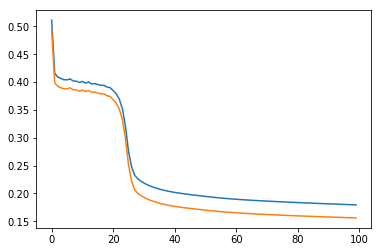

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
leaky_re_lu_57 (LeakyReLU)   multiple                  0         
_________________________________________________________________
attention_464 (Attention)    multiple                  1504      
_________________________________________________________________
flatten_2529 (Flatten)       multiple                  0         
_________________________________________________________________
dense_239 (Dense)            multiple                  119072    
Total params: 120,576
Trainable params: 120,576
Non-trainable params: 0
_________________________________________________________________


In [641]:
# Run a training batch
tf.set_random_seed(230) # Set seed

# Initialise model and optimiser
model = AttentionModel(hparams.input_dim, hparams.in_seq_len, hparams.output_dim, hparams.neurons_unit)
optimizer = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)

# Start training run
loss, accuracy, run_time, stats = train_model(model, optimizer, dataset, hparams, epochs=100, verbose=True)

# Display results
print('Loss {:.4f} Accuracy {:.4f} Time {:.4f}'.format(loss * 100, accuracy * 100, run_time))

plt.figure()
plt.plot(100*stats[:,:2])
plt.show()

model.summary()

In [646]:
loss, accuracy, run_time, stats = train_model(model, optimizer, dataset, hparams, epochs=100, verbose=True)

Epoch 1 Loss 0.1792 Accuracy 0.1558
Time taken for 1 epoch 4.8434 sec

Epoch 2 Loss 0.1790 Accuracy 0.1556
Time taken for 1 epoch 4.6996 sec

Epoch 3 Loss 0.1788 Accuracy 0.1555
Time taken for 1 epoch 4.4483 sec

Epoch 4 Loss 0.1786 Accuracy 0.1553
Time taken for 1 epoch 4.8450 sec

Epoch 5 Loss 0.1784 Accuracy 0.1551
Time taken for 1 epoch 4.8810 sec

Epoch 6 Loss 0.1782 Accuracy 0.1550
Time taken for 1 epoch 4.3947 sec

Epoch 7 Loss 0.1780 Accuracy 0.1548
Time taken for 1 epoch 4.4164 sec

Epoch 8 Loss 0.1778 Accuracy 0.1546
Time taken for 1 epoch 4.4423 sec

Epoch 9 Loss 0.1776 Accuracy 0.1544
Time taken for 1 epoch 4.6730 sec

Epoch 10 Loss 0.1774 Accuracy 0.1543
Time taken for 1 epoch 4.3708 sec

Epoch 11 Loss 0.1772 Accuracy 0.1541
Time taken for 1 epoch 4.4108 sec

Epoch 12 Loss 0.1770 Accuracy 0.1540
Time taken for 1 epoch 4.3694 sec

Epoch 13 Loss 0.1768 Accuracy 0.1538
Time taken for 1 epoch 4.7297 sec

Epoch 14 Loss 0.1766 Accuracy 0.1536
Time taken for 1 epoch 5.0119 sec

E

### Make Predictions

(100, 61, 1) (100, 61, 1)


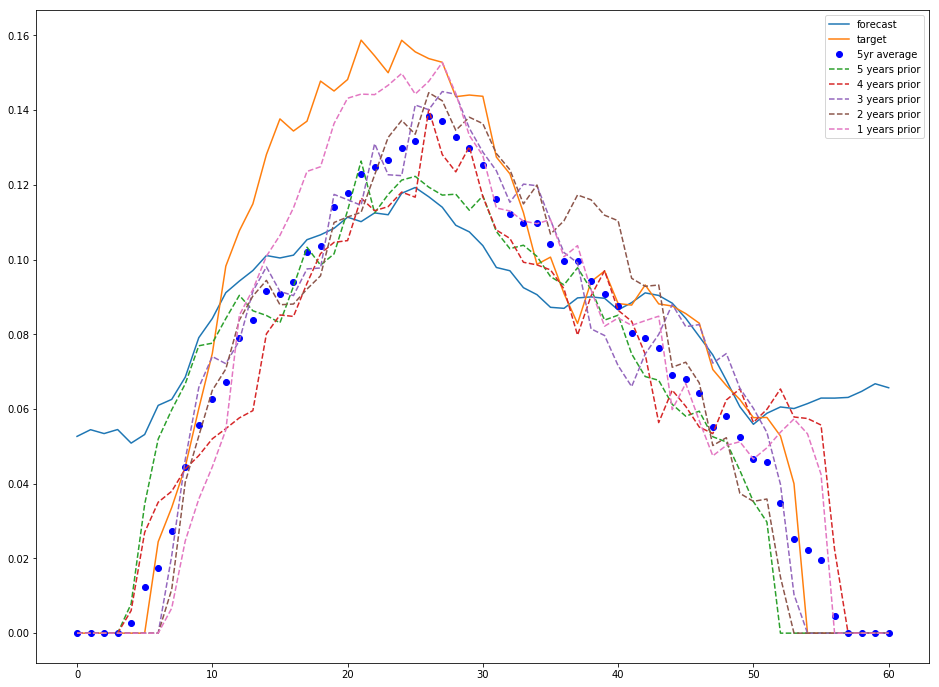

In [650]:
# empty string to store our results
TARGET_INDEX = 8
START_POINT = 0

_, (inp, target, mask) = enumerate(dataset).__next__()

forecast = model(inp, mask)

print(forecast.shape, target.shape)

# show target sequence
plt.figure(figsize=(16,12))
plt.plot(np.squeeze(forecast[TARGET_INDEX]), label='forecast')
plt.plot(np.squeeze(target[TARGET_INDEX]), label='target')
plt.plot(np.mean(inp, axis=2)[TARGET_INDEX], 'bo', label='5yr average')
for i in range(hparams.input_dim):
    plt.plot(np.array(inp)[TARGET_INDEX,:,i,0], '--', label='%i years prior' % (5-i))
plt.legend()
plt.show()

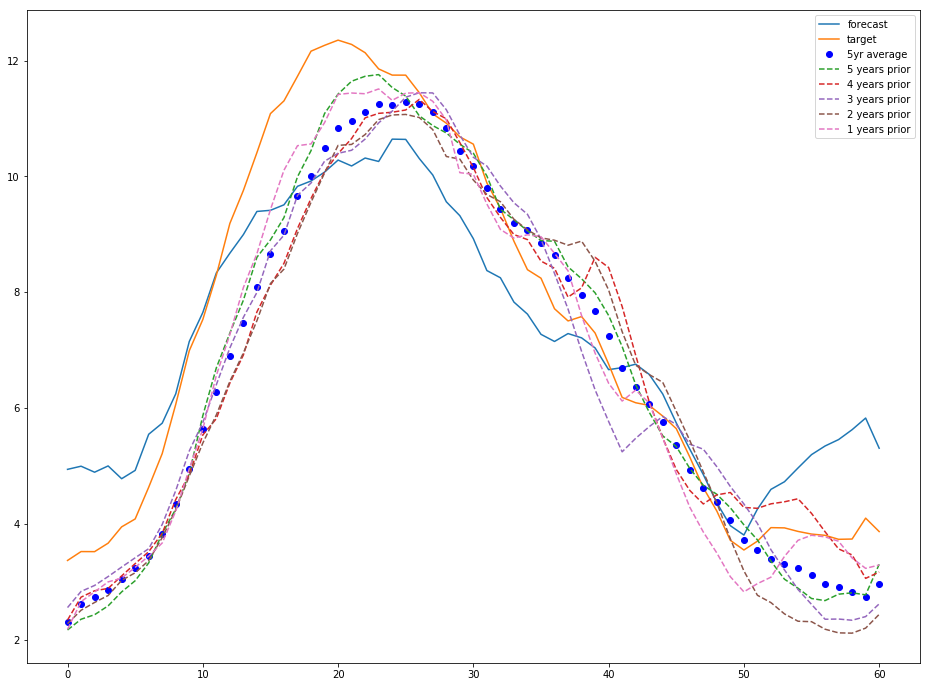

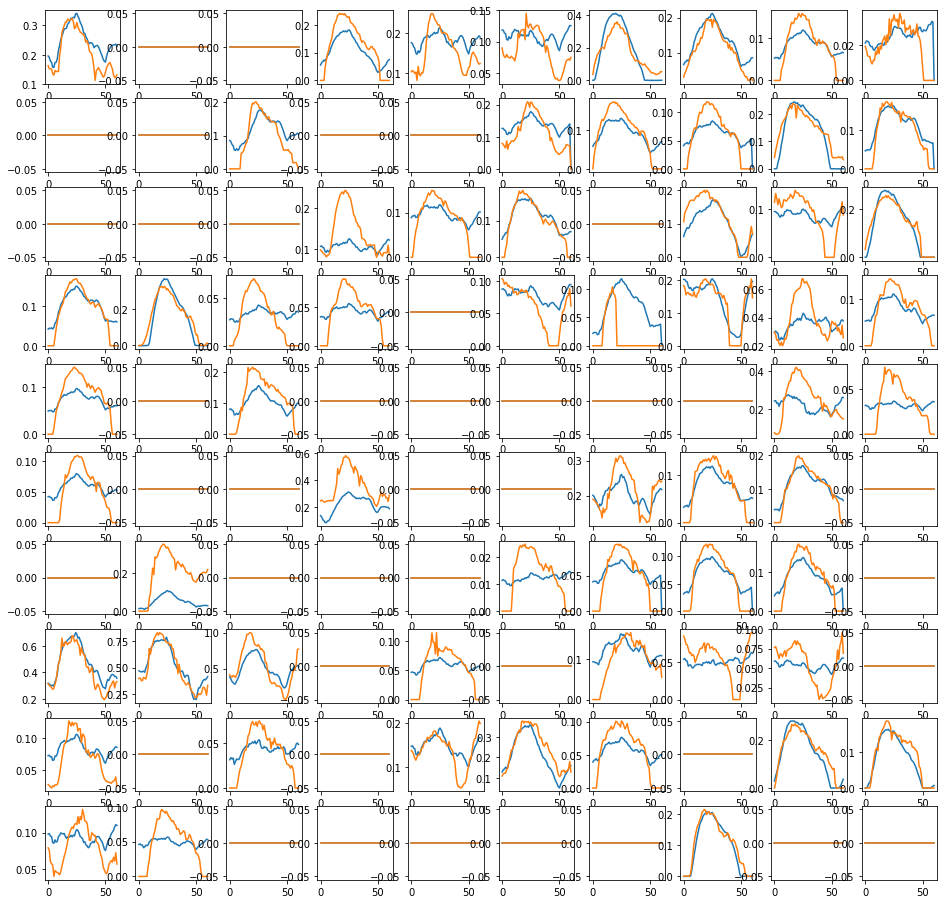

In [648]:
# show all sequences
plt.figure(figsize=(16,12))
plt.plot(np.sum(forecast, axis=(0,2)), label='forecast')
plt.plot(np.sum(target, axis=0), label='target')
plt.plot(np.sum(inp, axis=0).mean(axis=1), 'bo', label='5yr average')
for i in range(hparams.input_dim):
    plt.plot(np.sum(inp, axis=(0,3))[:,i], '--', label='%i years prior' % (5-i))

plt.legend()
plt.show()

plt.figure(figsize=(16,16))
for i in range(0,100):
    ax = plt.subplot(10,10,i+1)
    ax.plot(np.squeeze(forecast[i]), label='forecast')
    ax.plot(np.squeeze(target[i]), label='target')
plt.show()

In [644]:
l_ = np.sum((forecast - target) ** 2, axis=(1,2))
l_.argsort()

array([99, 73, 69, 26, 64, 63, 62, 60, 59, 45, 34, 54, 52, 51, 98, 41, 47,
       43, 44, 55, 22, 75, 20,  1,  2, 96, 95, 94, 93, 92, 87, 21, 11, 10,
       83, 13, 14, 81, 79, 46, 65, 38,  9, 82, 78, 32, 77, 49, 33, 89, 67,
       57, 86, 97, 58, 66, 25, 17, 37, 74,  7, 30, 50, 90, 91, 84, 80, 68,
       39, 19, 35, 40, 16,  8, 27,  5, 28, 88, 29, 56, 15, 76, 85, 24, 31,
       18,  3, 12,  4, 42,  0, 23,  6, 70, 36, 71, 48, 53, 61, 72])

### Test Hyperparameters

In [640]:
np.random.seed(231)
models, stats = [], []

lr    = np.log10(hparams.learning_rate)
nodes = hparams.neurons_unit

#for lr in np.random.uniform(-8, -1, 10):
#for nodes in np.floor(2 ** np.arange(3,9)):
for lr in range(-8, 0, 1):
    lr /= 2

    # Run a training batch
    tf.set_random_seed(231) # Set seed

    # Initialise model and optimiser
    model = AttentionModel(hparams.input_dim, hparams.in_seq_len, hparams.output_dim, int(nodes))
    optimizer = tf.train.AdamOptimizer(learning_rate = 10 ** lr)

    # Start training run
    loss, accuracy, run_time, stat = \
        train_model(model, optimizer, dataset, hparams, epochs = 5, verbose=False)
    print('Learning Rate {:.4f} Nodes {:.0f} Loss {:.4f} Accuracy {:.4f} Time {:.1f}'.format(
            lr, nodes, loss*100, accuracy * 100, run_time))
    
    models.append(model)
    stats.append(stat)

Learning Rate -4.0000 Nodes 32 Loss 0.4076 Accuracy 0.3901 Time 23.6
Learning Rate -3.5000 Nodes 32 Loss 0.4180 Accuracy 0.4008 Time 23.8
Learning Rate -3.0000 Nodes 32 Loss 0.4156 Accuracy 0.3992 Time 24.0
Learning Rate -2.5000 Nodes 32 Loss 0.4273 Accuracy 0.4094 Time 24.6
Learning Rate -2.0000 Nodes 32 Loss 0.4242 Accuracy 0.3898 Time 25.2
Learning Rate -1.5000 Nodes 32 Loss 2.8753 Accuracy 2.6087 Time 25.2
Learning Rate -1.0000 Nodes 32 Loss 7.0880 Accuracy 4.2598 Time 23.7
Learning Rate -0.5000 Nodes 32 Loss 564.5385 Accuracy 555.9460 Time 23.7
